# Predict stroke

Based on the dataset: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

In [1]:
extensions_loaded = False
if not extensions_loaded:
    %load_ext autoreload
    %load_ext tensorboard
    %autoreload 2
    %matplotlib inline
    extensions_loaded = True

%reload_ext autoreload

In [2]:
import matplotlib.pyplot as plt
import so_ml_tools as soml
import tensorflow as tf
import sklearn as sk
import keras as ks
import pandas as pd
import numpy as np
import seaborn as sns
import shap as sh

from sklearn import set_config
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline

2023-11-20 13:37:43.473364: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-20 13:37:43.473386: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-20 13:37:43.473412: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
ALL_DATA_CSV = 'data/healthcare-dataset-stroke-data.csv'

In [4]:
all_data = pd.read_csv(ALL_DATA_CSV)
all_data.head().T

,0,1,2,3,4
id,9046,51676,31112,60182,1665
gender,Male,Female,Male,Female,Female
age,67.0,61.0,80.0,49.0,79.0
hypertension,0,0,0,0,1
heart_disease,1,0,1,0,0
ever_married,Yes,Yes,Yes,Yes,Yes
work_type,Private,Self-employed,Private,Private,Self-employed
Residence_type,Urban,Rural,Rural,Urban,Rural
avg_glucose_level,228.69,202.21,105.92,171.23,174.12
bmi,36.6,NaN,32.5,34.4,24.0


# Drop ID column

In [5]:
soml.pd.dataframe.drop_columns(dataframe=all_data, column_names=['id'])

# Check data quality

In [6]:
soml.pd.dataframe.describe(dataframe=all_data)

Total number of rows: 5110


,Column,DType,NotNull,Null,Unique,Mean,Std,-3σ,3σ,Min,25%,50%,75%,Max
0,gender,object,5110,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,age,float64,5110,0,104,43.23,22.61,-24.61,111.06,0.08,25.00,45.00,61.00,82.00
2,hypertension,int64,5110,0,2,0.10,0.30,-0.79,0.99,0.00,0.00,0.00,0.00,1.00
3,heart_disease,int64,5110,0,2,0.05,0.23,-0.62,0.73,0.00,0.00,0.00,0.00,1.00
4,ever_married,object,5110,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,work_type,object,5110,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Residence_type,object,5110,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,avg_glucose_level,float64,5110,0,3979,106.15,45.28,-29.70,242.00,55.12,77.24,91.88,114.09,271.74
8,bmi,float64,4909,201,418,28.89,7.85,5.33,52.46,10.30,23.50,28.10,33.10,97.60
9,smoking_status,object,5110,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Column 'gender' is not visualized, the number of nunique values (3) either exceeds 50 or is lower then 3.
Column 'hypertension' is not visualized, the number of nunique values (2) either exceeds 50 or is lower then 3.
Column 'heart_disease' is not visualized, the number of nunique values (2) either exceeds 50 or is lower then 3.
Column 'ever_married' is not visualized, the number of nunique values (2) either exceeds 50 or is lower then 3.
Column 'Residence_type' is not visualized, the number of nunique values (2) either exceeds 50 or is lower then 3.
Column 'stroke' is not visualized, the number of nunique values (2) either exceeds 50 or is lower then 3.


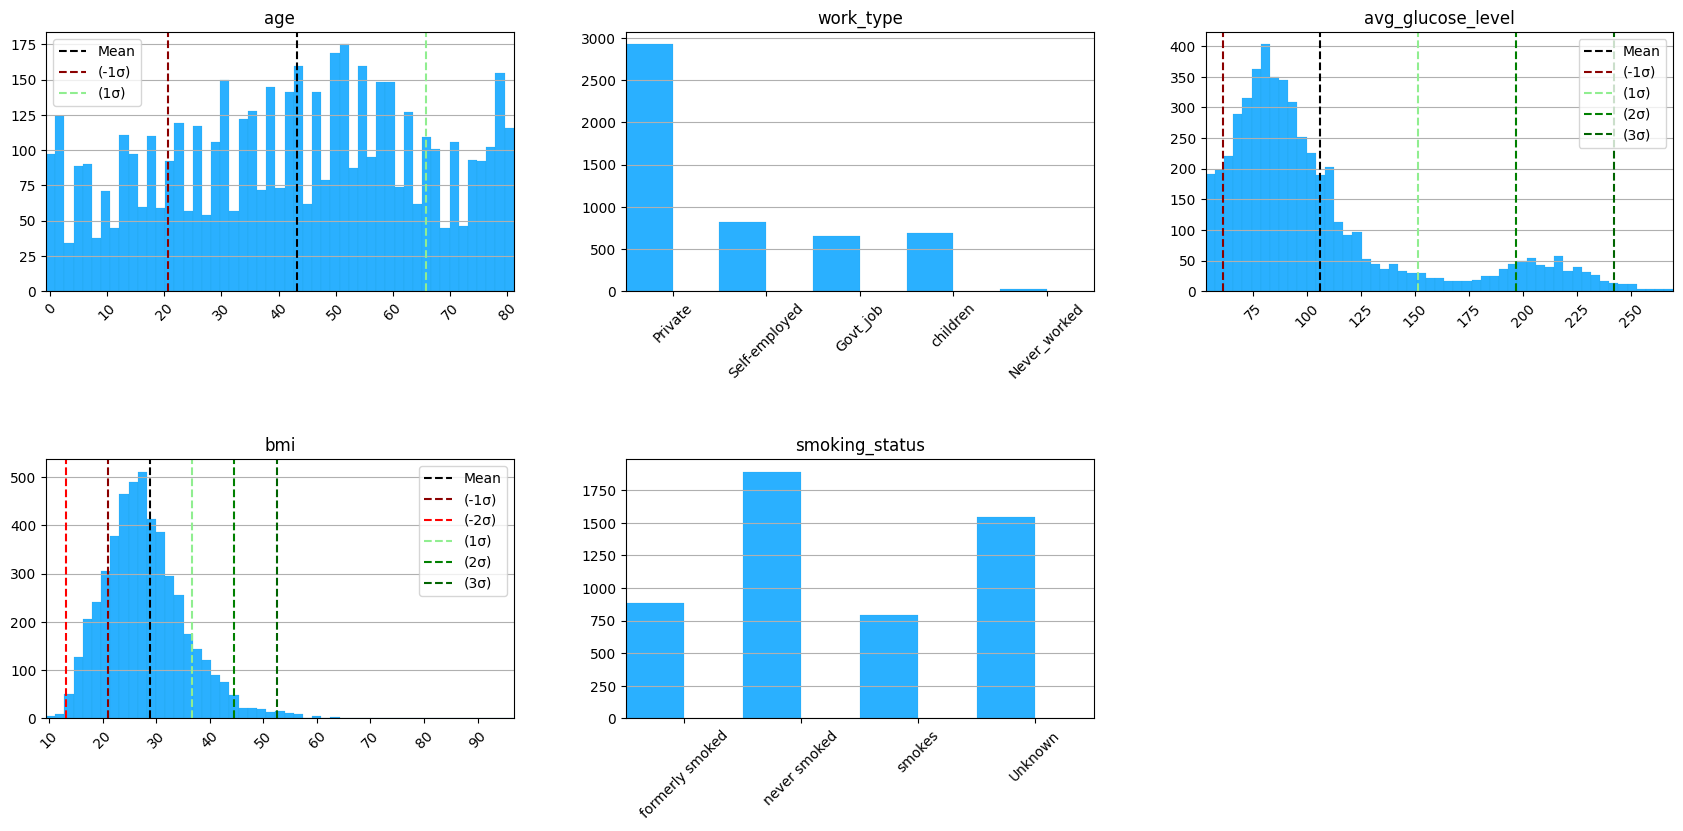

In [7]:
soml.pd.plot.histogram_for_columns(dataframe=all_data)

# Create a profile report

In [8]:
soml.pd.report.profile_report(dataframe=all_data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
soml.pd.dataframe.delete_rows_where_value_equal_to(dataframe=all_data, column_name='gender', value='Other', inplace=True)

In [10]:
soml.pd.dataframe.describe(dataframe=all_data)

Total number of rows: 5109


,Column,DType,NotNull,Null,Unique,Mean,Std,-3σ,3σ,Min,25%,50%,75%,Max
0,gender,object,5109,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,age,float64,5109,0,104,43.23,22.61,-24.61,111.07,0.08,25.00,45.00,61.00,82.00
2,hypertension,int64,5109,0,2,0.10,0.30,-0.79,0.99,0.00,0.00,0.00,0.00,1.00
3,heart_disease,int64,5109,0,2,0.05,0.23,-0.62,0.73,0.00,0.00,0.00,0.00,1.00
4,ever_married,object,5109,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,work_type,object,5109,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Residence_type,object,5109,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,avg_glucose_level,float64,5109,0,3978,106.14,45.29,-29.71,242.00,55.12,77.24,91.88,114.09,271.74
8,bmi,float64,4908,201,418,28.89,7.85,5.33,52.46,10.30,23.50,28.10,33.10,97.60
9,smoking_status,object,5109,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
import sklearn as sk

age_pipeline = sk.pipeline.Pipeline([
    ("imputer", soml.sklearn.imputer.SimpleGroupByImputer(column_name='bmi', group_by_column_name='age', agg_func='mean', remainder_agg_func='mean')),
    ("scaler", sk.preprocessing.MinMaxScaler())
])

# Set the output to standard, pandas cannot be used in case there is sparse data.
sk.set_config(transform_output='default')
ct = sk.compose.ColumnTransformer(transformers=[
    ("gender", sk.preprocessing.OneHotEncoder(categories=[[
        "Female", 
        "Male",
        "Other"]], sparse_output=True), ['gender']),
    ("age_minmax_", sk.preprocessing.StandardScaler(), ['age']),
    ("married", soml.sklearn.encoder.BooleanEncoder(value_zero='No', value_one='Yes'), ["ever_married"]),
    ("work", sk.preprocessing.OneHotEncoder(categories=[[
        'Private',
        'Self-employed',
        'Govt_job',
        'children',
        'Never_worked']], sparse_output=True), ['work_type']),
    ("residence", sk.preprocessing.OneHotEncoder(categories=[[
        'Urban',
        'Rural']], sparse_output=True), ['Residence_type']),
    ("glucose", sk.preprocessing.MinMaxScaler(), ['avg_glucose_level']),
    ("smoking", sk.preprocessing.OrdinalEncoder(categories=[[
        'never smoked',
        'formerly smoked',
        'smokes',
        'Unknown']]), ['smoking_status']),
    ("bmi", age_pipeline, ['bmi', 'age'])],
    verbose_feature_names_out=True,
    remainder='passthrough'
)

ct.fit(all_data)

ColumnTransformer(remainder='passthrough',
                  transformers=[('gender',
                                 OneHotEncoder(categories=[['Female', 'Male',
                                                            'Other']]),
                                 ['gender']),
                                ('age_minmax_', StandardScaler(), ['age']),
                                ('married',
                                 BooleanEncoder(value_one='Yes',
                                                value_zero='No'),
                                 ['ever_married']),
                                ('work',
                                 OneHotEncoder(categories=[['Private',
                                                            'Self-employed',
                                                            'Govt_job',
                                                            'children',
                                                            'Never_worked']])...
                                 ['Residence_type']),
                                ('glucose', MinMaxScaler(),
                                 ['avg_glucose_level']),
                                ('smoking',
                                 OrdinalEncoder(categories=[['never smoked',
                                                             'formerly smoked',
                                                             'smokes',
                                                             'Unknown']]),
                                 ['smoking_status']),
                                ('bmi',
                                 Pipeline(steps=[('imputer',
                                                  SimpleGroupByImputer(agg_func='mean',
                                                                       column_name='bmi',
                                                                       group_by_column_name='age',
                                                                       remainder_agg_func='mean')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['bmi', 'age'])])

In [12]:
result = ct.transform(all_data)
result_pd = pd.DataFrame(result, columns=ct.get_feature_names_out())
soml.pd.dataframe.describe(result_pd)

Total number of rows: 5109


,Column,DType,NotNull,Null,Unique,Mean,Std,-3σ,3σ,Min,25%,50%,75%,Max
0,gender__gender_Female,float64,5109,0,2,0.59,0.49,-0.89,2.06,0.00,0.00,1.00,1.00,1.00
1,gender__gender_Male,float64,5109,0,2,0.41,0.49,-1.06,1.89,0.00,0.00,0.00,1.00,1.00
2,gender__gender_Other,float64,5109,0,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,age_minmax___age,float64,5109,0,104,0.00,1.00,-3.00,3.00,-1.91,-0.81,0.08,0.79,1.71
4,married__ever_married,float64,5109,0,2,0.66,0.47,-0.77,2.08,0.00,0.00,1.00,1.00,1.00
5,work__work_type_Private,float64,5109,0,2,0.57,0.49,-0.91,2.06,0.00,0.00,1.00,1.00,1.00
6,work__work_type_Self-employed,float64,5109,0,2,0.16,0.37,-0.94,1.26,0.00,0.00,0.00,0.00,1.00
7,work__work_type_Govt_job,float64,5109,0,2,0.13,0.33,-0.88,1.13,0.00,0.00,0.00,0.00,1.00
8,work__work_type_children,float64,5109,0,2,0.13,0.34,-0.89,1.16,0.00,0.00,0.00,0.00,1.00
9,work__work_type_Never_worked,float64,5109,0,2,0.00,0.07,-0.19,0.20,0.00,0.00,0.00,0.00,1.00


# Split data into train / test

In [13]:
train_x, test_x = soml.data.split.split_train_test_data(result_pd)
len(train_x), len(test_x)

(4087, 1022)

In [14]:
train_y = soml.pd.dataframe.column_as_dataframe(dataframe=train_x, column_name='remainder__stroke', drop_after=True)
test_y = soml.pd.dataframe.column_as_dataframe(dataframe=test_x, column_name='remainder__stroke', drop_after=True)

len(train_y), len(test_y)

(4087, 1022)

In [15]:
input_layer = ks.layers.Input(shape=(train_x.shape[1]))
x = ks.layers.Dense(units=32, activation="relu")(input_layer)
x = ks.layers.Dense(units=16, activation="relu")(input_layer)
x = ks.layers.Dense(units=8, activation="relu")(input_layer)
output_layer = ks.layers.Dense(units=1, activation="sigmoid")(x)

base_model = ks.Model(input_layer, output_layer)
base_model.compile(loss=ks.losses.BinaryCrossentropy(),
                   optimizer=ks.optimizers.Adam(),
                   metrics=['accuracy'])

2023-11-20 13:37:52.317519: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


In [16]:
base_history = base_model.fit(x=train_x,
                              y=train_y,
                              epochs=10,
                              validation_data=(test_x, test_y))
                              

Epoch 1/10
128/128 [==============================] - 0s 1ms/step - loss: 0.5266 - accuracy: 0.7707 - val_loss: 0.3325 - val_accuracy: 0.9393
Epoch 2/10
128/128 [==============================] - 0s 607us/step - loss: 0.2386 - accuracy: 0.9542 - val_loss: 0.2376 - val_accuracy: 0.9393
Epoch 3/10
128/128 [==============================] - 0s 563us/step - loss: 0.1855 - accuracy: 0.9542 - val_loss: 0.2186 - val_accuracy: 0.9393
Epoch 4/10
128/128 [==============================] - 0s 517us/step - loss: 0.1711 - accuracy: 0.9542 - val_loss: 0.2076 - val_accuracy: 0.9393
Epoch 5/10
128/128 [==============================] - 0s 570us/step - loss: 0.1634 - accuracy: 0.9542 - val_loss: 0.2002 - val_accuracy: 0.9393
Epoch 6/10
128/128 [==============================] - 0s 558us/step - loss: 0.1587 - accuracy: 0.9542 - val_loss: 0.1950 - val_accuracy: 0.9393
Epoch 7/10
128/128 [==============================] - 0s 537us/step - loss: 0.1558 - accuracy: 0.9542 - val_loss: 0.1914 - val_accuracy: 0

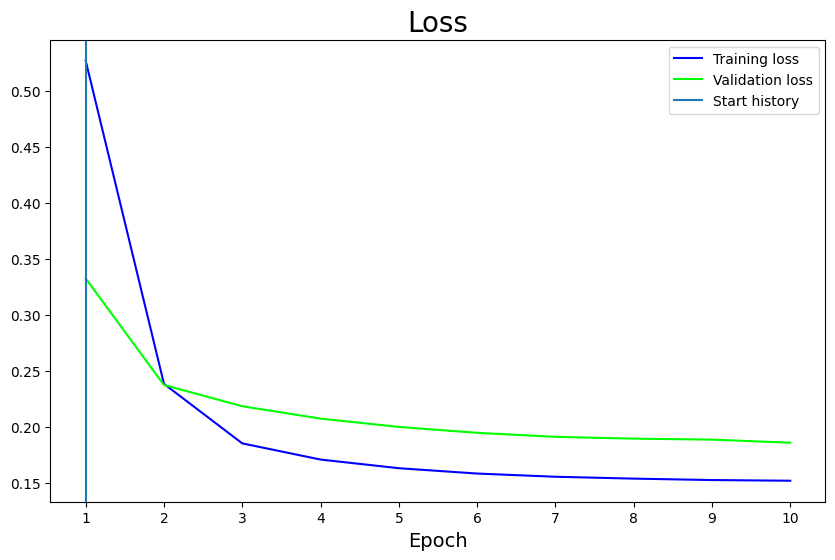

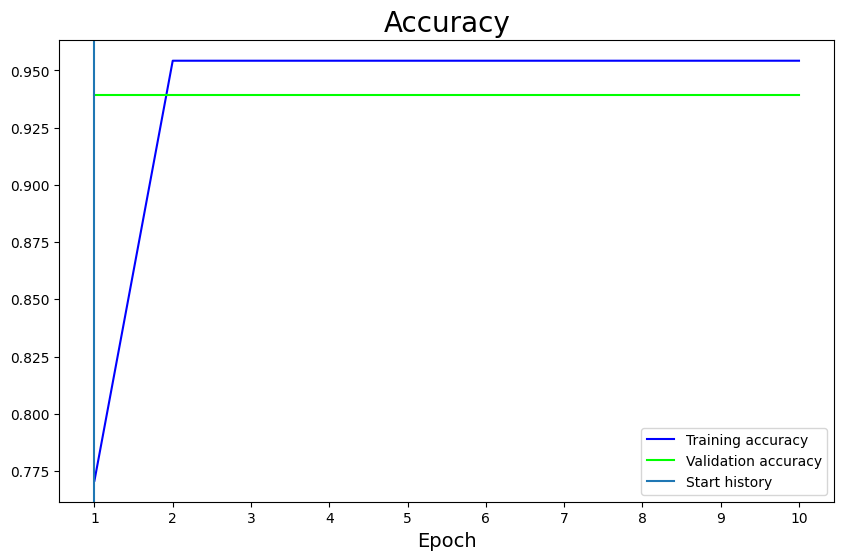

In [17]:
soml.tf.model.plot.plot_history(history=base_history)

In [54]:
import numpy as _np
def to_prediction_custom_threshold(y_prob: any, custom_threshold: float = 0.5) -> any:
    """
    Does the same as the to_prediction method except that it allows for a custom threshold, by default
    the to_prediction method will use the standard rounding function, meaning a threshold of 0.5, using this
    method you can define your own threshold.

    Args:
        y_prob: the probabilities matrix either a 'list' or an 'np.array'
        custom_threshold: threshold value for when the result is either a 0 or a 1 ( >= threshold)

    Raises:
        TypeError: If `y_prob` is neither a 'list' nor 'np.array'
    """
    if soml.util.label.is_binary_classification(y_prob=y_prob):
        if isinstance(y_prob, list):
            return [[1.0] if y[0] >= custom_threshold else [0.0] for y in y_prob]
        elif isinstance(y_prob, _np.ndarray):
            return _np.where(y_prob > custom_threshold, 1, 0)

    raise TypeError('y_prob should be of type np.array or list.')

In [57]:
import soml.util.label.to_prediction_custom_threshold as to_prediction_custom_threshold

y_prob = base_model.predict(x=test_x)

y_prob_ct = to_prediction_custom_threshold(y_prob=y_prob, custom_threshold=0.1)

32/32 [==============================] - 0s 328us/step


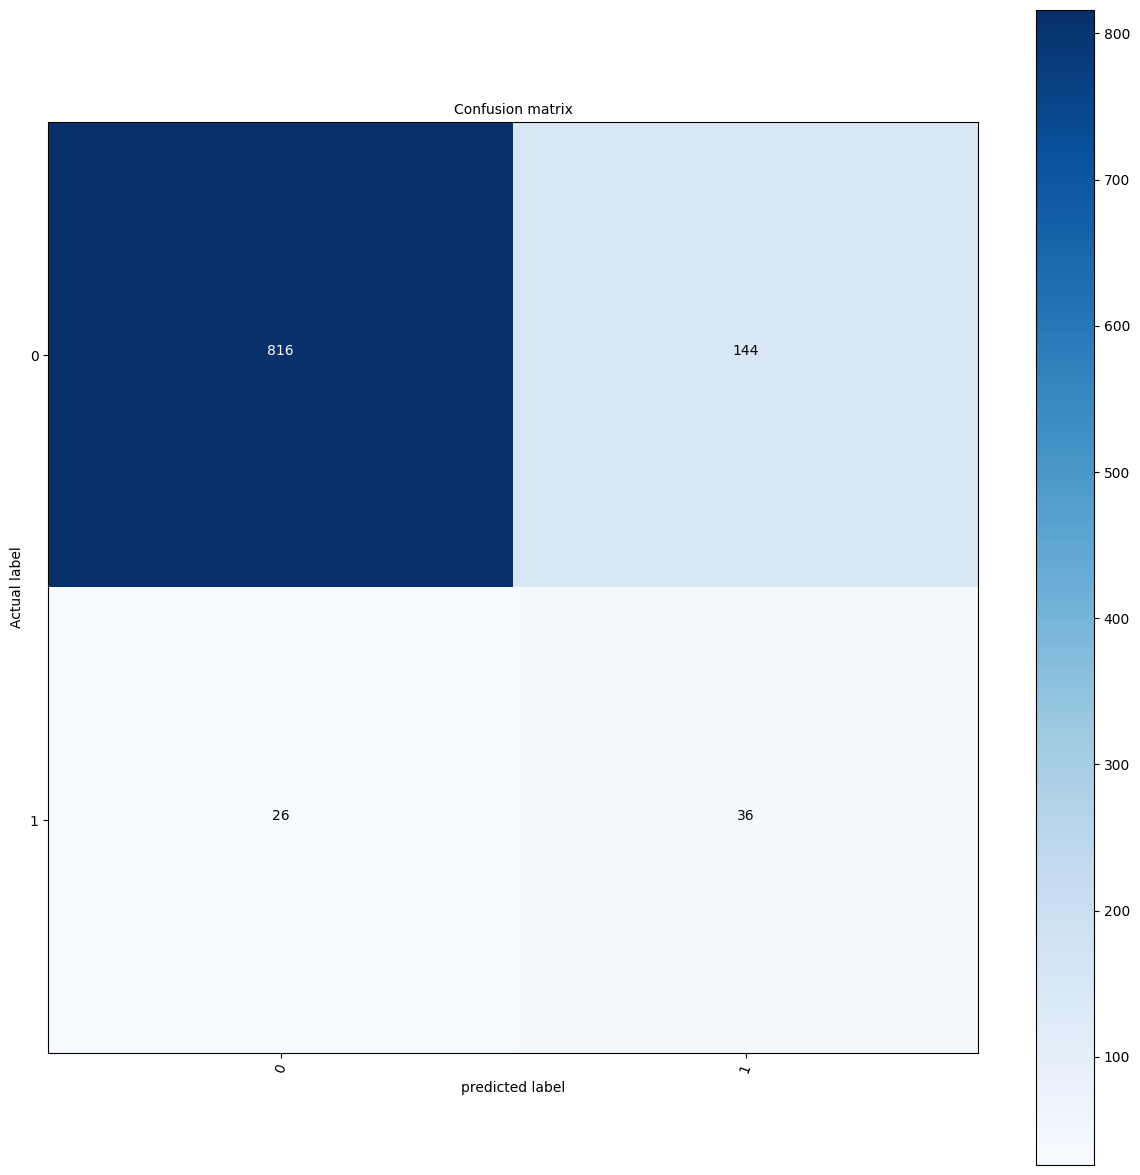

In [58]:
soml.evaluate.plot.confusion_matrix(y_true=test_y, y_prob=y_prob_ct)

In [19]:
soml.evaluate.analyze.quality_metrics(y_true=test_y, y_prob=y_prob)

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,accuracy,f1-score,precision,recall
0,93.933464,0.909951,0.88235,0.939335


In [20]:
sk.metrics.average_precision_score(y_true=test_y, y_score=y_prob)

0.21057183718218908

In [21]:
precision, recall, thresholds = sk.metrics.precision_recall_curve(y_true=test_y, probas_pred=y_prob)

In [22]:
auc_precision_recall = sk.metrics.auc(recall, precision)
auc_precision_recall

0.20094355939320463

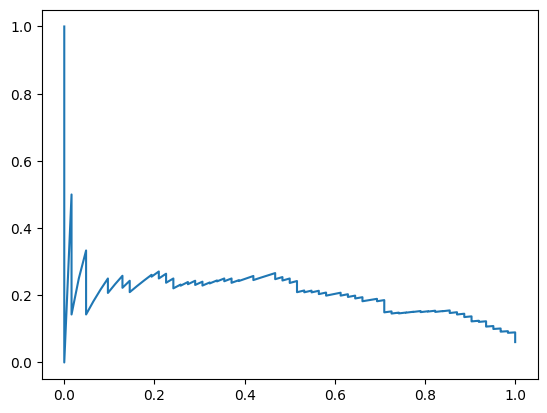

In [23]:
import matplotlib.pyplot as plt
plt.plot(recall, precision)
plt.show()